In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import mpltern
import polyphase
plt.rcParams.update({"text.usetex": True})

from scipy.spatial.distance import pdist, euclidean
from itertools import combinations 
from matplotlib import cm
from matplotlib import colors

In [30]:
M = [64,1,1]
chi = [1,0.3,0.2]


# M = [5,5,1]
# chi = [1,0.5,0.5]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,200, 3)
engine.compute(thresh_scale=10)

Computation took 41.63s


In [31]:
def Chii(chi):
    chi1 = 0.5*(chi[0]+chi[1]-chi[2])
    chi2 = 0.5*(chi[0]+chi[2]-chi[1])
    chi3 = 0.5*(chi[2]+chi[1]-chi[0])
    
    return [chi1, chi2, chi3]
    
def psi(phi, M, chi):
    psii = []
    chii = Chii(chi)
    for i in range(3):
        psii.append((M[i]*phi[i])/(1-2*chii[i]*M[i]*phi[i]))
        
    return psii

[-0.13142721  0.13696192  0.99446529] [-4.35651515e-13  1.99236183e-11  0.00000000e+00]


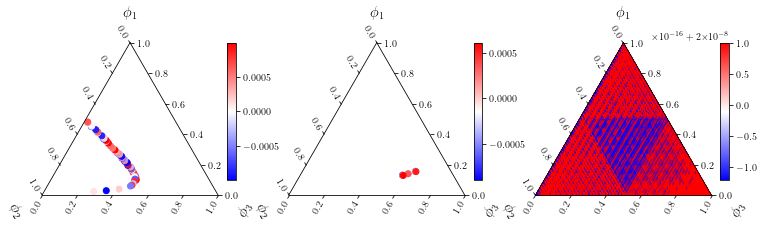

In [32]:
# compute critical point and draw spinodal points
from scipy.optimize import fsolve

def equations(phi, M, chi):
    psii = psi(phi, M, chi)
    chii = Chii(chi)
    
    t1 = sum(psii)
    t2 = 0
    for i in range(3):
        t2 += M[i]*psii[i]*((1+2*chii[i]*psii[i])**2)
    
    t3 = sum(phi)-1
    
    return [t1,t2,t3]

sol,info,ier,msg =  fsolve(equations, [0.5, 0.5, 0], args=(M,chi),full_output=True)
print(sol, info['fvec'])

residuals = np.asarray([equations(x,M,chi) for x in engine.grid.T])
fig, axs = plt.subplots(1,3,figsize=(4*3, 4), subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    inrange = np.abs(residuals[:,i])<=1e-3
    im = axs[i].scatter(engine.grid[0,inrange], engine.grid[1,inrange], engine.grid[2,inrange], 
                   c=residuals[inrange,i], cmap='bwr')
    axs[i].set_tlabel(r'$\phi_1$', fontsize=15)
    axs[i].set_llabel(r'$\phi_2$', fontsize=15)
    axs[i].set_rlabel(r'$\phi_3$', fontsize=15)
    
    cax = axs[i].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[i].transAxes)
    fig.colorbar(im, cax=cax, pad=0.15)

In [45]:
class BinodalConditions:
    def __init__(self, engine, m,chi,eps=1e-5):
        self.engine = engine
        self.m = m
        self.chi = chi
        
        self.eps = eps

    def get_chemical_potential(self, phi):
        mu_1 = (phi[1]**2)*chi[0] + (phi[2]**2)*self.chi[1] + \
        phi[2]*(1-(1/self.m) + phi[1]*(self.chi[0]+self.chi[1]-self.chi[2]))+np.log(phi[0])
        
        mu_2 = ((phi[1]-1)**2)*self.chi[0] + (phi[2]**2)*self.chi[1] - phi[2]/self.m + \
        phi[2]*(1+(phi[1]-1)*(self.chi[0]+self.chi[1])+self.chi[2]-(phi[1]*self.chi[2]))+np.log(phi[1])
        
        mu_3 = 1-phi[2]+self.m*(-1 + self.chi[1] + (phi[2]**2)*self.chi[1] + \
                                phi[2]*(1-2*self.chi[1]+phi[1]*(self.chi[0]+self.chi[1]-
                                                                self.chi[2]))) + \
        self.m*phi[1]*((phi[1]-1)*self.chi[0]-self.chi[1]+self.chi[2]) +np.log(phi[2])
        
        return np.asarray([mu_1, mu_2, mu_3])
    
    def _compute_residual(self,val1, val2, scale, formula=1):
        diff = val1 - val2
        if formula==1:
            scale = 1 #Formula 1
        elif formula==2:
            scale = scale #Formula 2
        elif formula==3:
            scale = 0.5*(val1+val2)+self.eps # Formula 3
        elif formula==4:
            scale = 0.5*(np.abs(val1)+np.abs(val2))+self.eps # Formula 3

        residual = np.abs(diff/scale)     
        return residual
    
    def get_binodal_conditions(self,phi_1, phi_2, formula=0):
        self.mu1 = self.get_chemical_potential(phi_1)
        self.mu2 = self.get_chemical_potential(phi_2)

        t1 = self._compute_residual(self.mu1[0], self.mu2[0], -20,formula=formula)
        t2 = self._compute_residual(self.mu1[1], self.mu2[1], -20,formula=formula)
        t3 = self._compute_residual(self.mu1[2], self.mu2[2], -85,formula=formula)

        return np.asarray([t1,t2,t3])
  
    def evaluate_simplex(self, simplex, threshold=1e-3,**gbc_kwargs):
        points = np.asarray([self.engine.grid[:,x] for x in simplex])
        indx = list(combinations(range(3),2))
        self.max_edge_verts = indx[np.argmax(pdist(points))]
        self.phi_1 = points[self.max_edge_verts[0],:]
        self.phi_2 = points[self.max_edge_verts[1],:]

        residuals = self.get_binodal_conditions(self.phi_1,self.phi_2,**gbc_kwargs)
        flag = (residuals<threshold).all()

        return points, residuals, flag

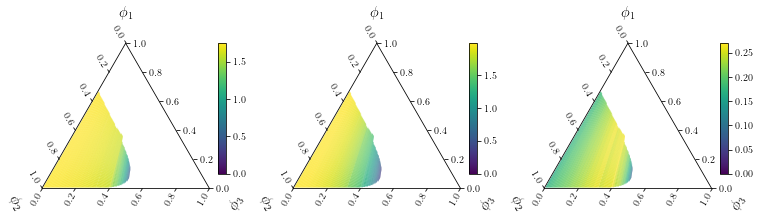

In [52]:
PHASE_ID = 2
PHASE_ID_SIMPLICES = engine.simplices[np.asarray(engine.num_comps)==PHASE_ID]
BCTest = BinodalConditions(engine,M[0],chi)

fig, axs = plt.subplots(nrows=1, ncols=3,
                        figsize=(4*3,4),
                        subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.5)
failed = []

FORMULA = 4
norms_dict = {1:[plt.Normalize(0,4.01), plt.Normalize(0,0.664), plt.Normalize(0,12.03)],
             2:[plt.Normalize(0,0.2), plt.Normalize(0,0.03), plt.Normalize(0,0.14)],
             3:[plt.Normalize(0,1.75), plt.Normalize(0,1.99), plt.Normalize(0,0.27)],
             4:[plt.Normalize(0,1.75), plt.Normalize(0,1.99), plt.Normalize(0,0.27)]}
norm = norms_dict[FORMULA]

cmap = cm.viridis

residuals = []
for simplex in PHASE_ID_SIMPLICES:
    points, residual, flag = BCTest.evaluate_simplex(simplex, threshold=1e-4,formula=FORMULA)
    residuals.append(residual)
    for i in range(3):
        axs[i].fill(points[:,0], points[:,1], points[:,2],
                    facecolor=cmap(norm[i](residual[i])))
        
for i,ax in enumerate(axs):
    ax.set_tlabel(r'$\phi_1$', fontsize=15)
    ax.set_llabel(r'$\phi_2$', fontsize=15)
    ax.set_rlabel(r'$\phi_3$', fontsize=15)
    cax = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
    fig.colorbar(cm.ScalarMappable(norm=norm[i], cmap=cmap), cax=cax)
plt.show()        

In [51]:
np.max(residuals,axis=0)

array([1.75339129, 1.9994137 , 0.27151184])

In [ ]:
# plot chemical potentials
chempots = np.asarray([BCTest.get_chemical_potential(x) for x in engine.grid.T])
fig, axs = plt.subplots(1,3,figsize=(4*3, 4), subplot_kw={'projection':'ternary'})
fig.subplots_adjust(wspace=0.4)
for i in range(3):
    im = axs[i].scatter(engine.grid[2,:], engine.grid[0,:], engine.grid[1,:], 
                   c=chempots[:,i], cmap='bwr')
    axs[i].set_tlabel(r'$\phi_1$', fontsize=15)
    axs[i].set_llabel(r'$\phi_2$', fontsize=15)
    axs[i].set_rlabel(r'$\phi_3$', fontsize=15)
    
    cax = axs[i].inset_axes([1.05, 0.1, 0.05, 0.9], transform=axs[i].transAxes)
    cbar = fig.colorbar(im, cax=cax, pad=0.15)
    cbar.set_label(r'$\mu_{}$'.format(i))
    
plt.show()